# Final Project

This project aims to use land surface reflectance data to simulate CO2 concentration.

Dataset:

feature dataset: MOD09CMG, grid data, with a spatial resolution of 0.05 degree. Band1, band2, band3, band4 and band7 are used in the subsequent computation.

See https://lpdaac.usgs.gov/products/mod09cmgv061/.

labelled dataset: OCO2, orbital data, with a spatial resoution of 2.25 km x 1.29 km.

See https://disc.gsfc.nasa.gov/datasets/OCO2_L2_Lite_FP_11.1r/summary?keywords=oco-2.

All the dataset used can be download from github.

Data Preprocessing: The OCO-2 data has been regridded to 0.05 degree, the same resolution with MOD09CMG data.

Method: Random Forest Method is used to simulate CO2 with surface reflectance data. Here we split global coverage dataset into 5 * 5 degree window and used Random Foresrt Method in this window.

The script 1.tutorial of the main process is a tutorial about the process, which helps to be familiar with the data and understand the process.

This script 2.function of the main process is a function which intergrates the important steps in 1.tutorial of the main process and aims to reproduce the process quickly.

__Note__: please change the file directory in the first function *data_split*.

In [78]:
def data_split(left_longitude, top_latitude):
    
    """
    Get regions of interest from the global coverage data
    
    PARAMETERS
    ----------
    left_longitude : int
        The west of the moving window.
    top_latitude : int
        The north of the moving window.
        
    RETURNS
    -------
    all dataset used for subsequent analysis : Dictionary
        {'CO2_roi':CO2_roi,'band1_roi':band1_roi,'band2_roi':band2_roi,'band3_roi':band3_roi,'band4_roi':band4_roi,'band7_roi':band7_roi} 
    """
    
    # import package
    import numpy as np
    
    # calculate start row and start col in the big dataset
    start_row = (left_longitude+180)/0.05
    start_col = int((90-top_latitude)/0.05)
    
    ###### Note that you have to change the directory of the file by yourself ######
    CO2 = np.loadtxt('/home/sh1776/miniforge3/Final_project/CO2_201501.csv',delimiter=',')
    band1 = np.loadtxt('/home/sh1776/miniforge3/Final_project/Band_1.csv',delimiter=',') 
    band2 = np.loadtxt('/home/sh1776/miniforge3/Final_project/Band_2.csv',delimiter=',') 
    band3 = np.loadtxt('/home/sh1776/miniforge3/Final_project/Band_3.csv',delimiter=',') 
    band4 = np.loadtxt('/home/sh1776/miniforge3/Final_project/Band_4.csv',delimiter=',') 
    band7 = np.loadtxt('/home/sh1776/miniforge3/Final_project/Band_7.csv',delimiter=',') 
    
    # get the regions of interest
    CO2_roi = CO2[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    band1_roi = band1[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    band2_roi = band2[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    band3_roi = band3[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    band4_roi = band4[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    band7_roi = band7[int(start_col):int(start_col+100),int(start_row):int(start_row+100)]
    return {'CO2_roi':CO2_roi,'band1_roi':band1_roi,'band2_roi':band2_roi,'band3_roi':band3_roi,'band4_roi':band4_roi,'band7_roi':band7_roi}

In [72]:
def CO2_RF_simulation(data):
    """
    Simulate CO2 concentration of the region
    
    PARAMETERS
    ----------
    data : dictionary
        Output of data_split function.
        
    RETURNS
    -------
    model accuracy measures and the prediction result: Dictionary.
        {'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,'predict_CO2':predict_CO2} 
    """
    # import packages
    import xarray as xr
    import pandas as pd
    from matplotlib import pyplot as plt
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor

    # load the data
    CO2 = data['CO2_roi']
    band1 = data['band1_roi']
    band2 = data['band2_roi']
    band3 = data['band3_roi']
    band4 = data['band4_roi']
    band7 = data['band7_roi']


    # data preprocessing
    predict_band1 = band1.reshape(10000)
    predict_band2 = band2.reshape(10000)
    predict_band3 = band3.reshape(10000)
    predict_band4 = band4.reshape(10000)
    predict_band7 = band7.reshape(10000)
    predict_features = np.transpose(np.vstack((predict_band1,predict_band2,predict_band3,predict_band4,
                                   predict_band7)))
    all_label = CO2.reshape(10000)
    all_feature = predict_features[~np.isnan(all_label),:]
    all_label = all_label[~np.isnan(all_label)]

    # split the dataset
    train_features, test_features, train_labels, test_labels = train_test_split(all_feature, all_label, test_size = 0.3, random_state=2) 
    
    # build the model
    reg_rf = RandomForestRegressor(n_estimators = 1000,random_state = 42)
    reg_rf.fit(train_features, train_labels)

    # model accuracy
    # calculate RMSE as a measure of model accuracy
    RMSE_train=np.sqrt(np.square(reg_rf.predict(train_features)-train_labels).sum()/test_labels.shape[0])
    RMSE_test=np.sqrt(np.square(reg_rf.predict(test_features)-test_labels).sum()/test_labels.shape[0])
    
    # model prediction
    nan_rows = np.isnan(predict_features).any(axis=1) ### If there is nan rows, we can skip this row when using random forest model
    predict_features1 = predict_features[~nan_rows, :]
    predict_result = reg_rf.predict(predict_features1)
    predict_CO2 = np.full([10000], np.nan) # 100*100
    predict_CO2[~nan_rows] = predict_result
    predict_CO2 = predict_CO2.reshape(100,100)

    
    return {'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,'predict_CO2':predict_CO2}

Here is an example of these functions.

__Note__:Since the CO2 concentration data is so sparse, we select this region with more samples compared with others.

In [79]:
data = data_split(65,-10)
data

{'CO2_roi': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'band1_roi': array([[ 0.0055,  0.0065,  0.033 , ...,  0.0645,  0.0511,  0.    ],
        [ 0.001 ,  0.0321,  0.0993, ...,  0.0424,  0.0264,  0.0157],
        [ 0.0049, -0.0008,  0.0263, ...,  0.0541,  0.0561,  0.047 ],
        ...,
        [ 0.0428,  0.075 ,  0.0385, ...,  0.0674,  0.0345,  0.0262],
        [ 0.0781,  0.0588,  0.0297, ...,  0.0249,  0.0059,  0.0111],
        [ 0.1254,  0.0575,  0.0171, ...,  0.0175,  0.0163,  0.016 ]]),
 'band2_roi': array([[ 0.0028,  0.0038,  0.0296, ...,  0.0637,  0.0504,  0.0027],
        [-0.001 ,  0.032 ,  0.0955, ...,  0.0423,  0.0275,  0.0173],
        [ 0.0033, -0.0022,  0.0248, ...,  0.0534,  0.0557,  0.0472],
        ...,
        [ 0.041 ,  0.0745,  0

In [74]:
data['CO2_roi']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [75]:
result = CO2_RF_simulation(data)

In [76]:
result

{'RMSE_train': 0.7033582560633512,
 'RMSE_test': 1.5253370408946911,
 'predict_CO2': array([[397.6238 , 398.3796 , 398.71482, ..., 398.59007, 398.17968,
         398.67884],
        [398.5467 , 398.61983, 399.39211, ..., 398.22694, 398.55713,
         398.18359],
        [398.32836, 398.19975, 398.17409, ..., 398.14317, 398.16436,
         398.16566],
        ...,
        [398.36554, 397.3633 , 397.7355 , ..., 398.03277, 397.75761,
         398.48464],
        [396.9813 , 398.35078, 398.45898, ..., 398.37636, 398.05996,
         398.24236],
        [399.39092, 397.91985, 397.64666, ..., 398.22397, 398.18064,
         398.13882]])}

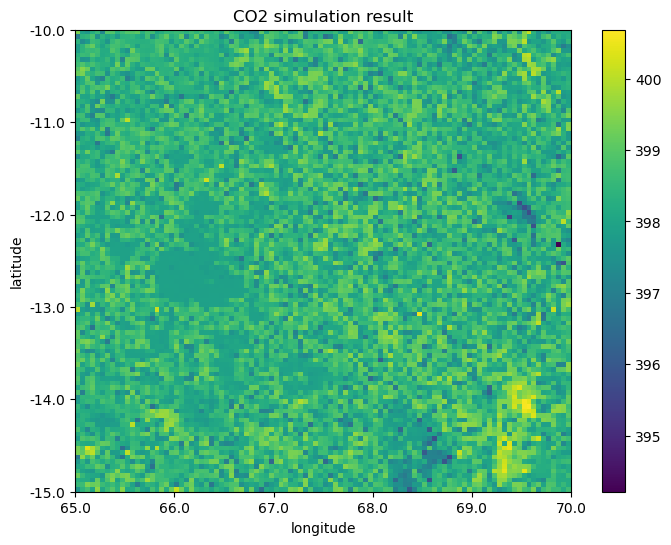

In [77]:
# visualize the prediction as 1.tutorial of the main process
predict_CO2 = result['predict_CO2']
predict_CO2_plot = np.flip(predict_CO2, axis=0) 
# The step is to inverse the row of the dataset for plot. If we don't do that, the first row (north) will be on the bottom,
# while the last rown (south) will be on the top.

fig, ax =  plt.subplots(figsize=(8,6))
meshplot = ax.pcolormesh(predict_CO2)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('CO2 simulation result')
fig.colorbar(meshplot) # add color bar
ax.set_xticks(np.arange(0,101,20),np.arange(-180+4900*0.05,-180+5000*0.05+1)) # select the 4900:5000 column from global coverage
ax.set_yticks(np.arange(0,101,20),np.arange(90-2100*0.05,90-2000*0.05+1)) # select the 2000:2100 column from global coverage# view the dataset